# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

(array([1.4089e+04, 2.7087e+04, 2.6777e+04, 1.8472e+04, 9.1850e+03,
        3.4150e+03, 7.6600e+02, 1.7900e+02, 2.8000e+01, 2.0000e+00]),
 array([ 2. , 11.2, 20.4, 29.6, 38.8, 48. , 57.2, 66.4, 75.6, 84.8, 94. ]),
 <BarContainer object of 10 artists>)

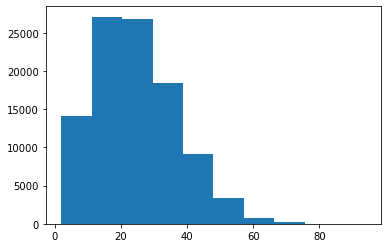

In [49]:
import numpy as np
import pandas as pd
from random import choices
import random
import matplotlib.pyplot as plt

d = 365
N = 100000

df = pd.read_csv('us_births_69_88.csv')
births = df['births']
births.reset_index()

max_cnt = births.max()
size = births.size

def sample_day():
    day = random.randint(1, size - 1)
    if random.randint(1, max_cnt) <= births[day]:
        return day
    return sample_day()

def sample_day():
    while True:
        day = random.randint(1, size - 1)
        if random.randint(1, max_cnt) <= births[day]:
            return day


def foo():
    occured = set()
    i = 0
    while True:
        num = sample_day()
        i += 1
        if num in occured:
            return i
        occured.add(num)
    
results = np.array([foo() for _ in range(N)])
plt.hist(results)

In [53]:
births.max()

212915

**Problem 2b.** One of the reasons this implementation is not significantly faster than the one in **Problem 1c** , apart from $d$ being rather small, is that we are using Python's interpreter a bit too much, and Python is slow. One way around this is usually to use a library function - **searchsorted** is much faster than an equivalent code implemented in pure Python. But even if the functionality you need is not implemented in a lower level language as
a library function, there is still hope. You can try to implement it using optimized array algebra, for example using **numpy**. In this problem, your task is to rewrite the previous algorithm, so that the amount of *looping* is reduced to a minimum necessary. In particular, you should create a *vectorized* version of random dates generation (in bulk), while the actual search for duplicates remains a loop with a **set**. Here are some useful tips:
   * You can perform arithmetic, comparisons, etc. on **numpy** arrays.
   * You can generate whole **numpy** arrays of random numbers at once.
   * You can even perform parallel look-up like in the example below.

sample: 373
days size: 669
sample: 373
days size: 664
sample: 373
days size: 655
sample: 373
days size: 664
sample: 373
days size: 676
sample: 373
days size: 662
sample: 373
days size: 674
sample: 373
days size: 670
sample: 373
days size: 646
sample: 373
days size: 657
sample: 373
days size: 668
sample: 373
days size: 680
sample: 373
days size: 662
sample: 373
days size: 666
sample: 373
days size: 666
sample: 373
days size: 659
sample: 373
days size: 669
sample: 373
days size: 670
sample: 373
days size: 661
sample: 373
days size: 663
sample: 373
days size: 669
sample: 373
days size: 672
sample: 373
days size: 647
sample: 373
days size: 670
sample: 373
days size: 658
sample: 373
days size: 664
sample: 373
days size: 667
sample: 373
days size: 659
sample: 373
days size: 667
sample: 373
days size: 677
sample: 373
days size: 673
sample: 373
days size: 657
sample: 373
days size: 662
sample: 373
days size: 668
sample: 373
days size: 671
sample: 373
days size: 674
sample: 373
days size: 659
s

(array([1.1780e+04, 2.6306e+04, 2.7601e+04, 1.9345e+04, 9.7670e+03,
        3.8450e+03, 1.0770e+03, 2.3200e+02, 4.0000e+01, 7.0000e+00]),
 array([ 2. , 10.9, 19.8, 28.7, 37.6, 46.5, 55.4, 64.3, 73.2, 82.1, 91. ]),
 <BarContainer object of 10 artists>)

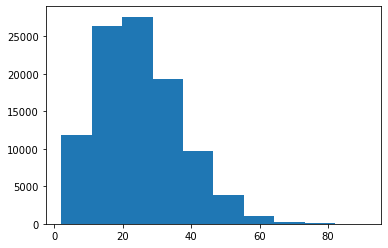

In [68]:
import numpy as np
import pandas as pd
from random import choices
import random
import matplotlib.pyplot as plt

d = 365
N = 100000

df = pd.read_csv('us_births_69_88.csv')
births = df['births']
births.reset_index()

max_cnt = births.max()
size = births.size

def sample_days(chunk_size: int):
    print('sample:', chunk_size)
    # we want to generate chunk_size numbers
    # P(randints_for_repeat[i] <= births[day])
    # ~= P(randint(1, max_cnt) <= mean_births)
    # = P(randint(1, 212k) <= 190k)
    # ~= 0.9
    # E[nums after k iterations] = 0.9 * k
    # E[nums after k iterations] > chunk_size iff 0.9 * k > chunk_size
    # iff k > chunk_size * 10 / 9
    # let's just take 2 > 10 / 9
    expected_rounds = chunk_size * 2

    days = np.random.randint(1, size - 1, size=expected_rounds)
    sim_births = np.random.randint(1, max_cnt, size=expected_rounds)
    real_births = births[days]
    days = days[sim_births <= real_births]

    print('days size:', days.size)
    if days.size < chunk_size:
        sample_days(chunk_size - days.size)
    yield from days


def foo():
    chunk_size = size + 1  # we're guaranteed to find a collision with size+1 values from [1, size - 1]
    occured = set()
    i = 0
    days = sample_days(chunk_size)
    for i, num in enumerate(days):
        if num in occured:
            return i + 1
        occured.add(num)
    
results = np.array([foo() for _ in range(N)])
plt.hist(results)

# expected_rounds = 100
# days = np.random.randint(1, size - 1, size=expected_rounds)
# sim_births = np.random.randint(1, max_cnt, size=expected_rounds)
# real_births = births[days]
# real_births.size
# days[sim_births <= real_births].size

**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.


**Problem 2d.** Show that the frequency histogram for empirical birthday frequencies can actually be computed exactly, and implement your idea. To this end, design a recurence relation using conditional probabilities and use dynamic programming.

**BONUS**. An alternative plotting library: plotly

In [ ]:
#install plotly with: pip install plotly
#you can run this shell command directly from Jupyter, by prefixing it with !
!pip install plotly

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import numpy as np

init_notebook_mode(connected=True)

# example scatterplot

x = np.linspace(0, 1, 10)
y = x * x

iplot([go.Scatter(x=x, y=y, name="y=x^2"), go.Scatter(x=x, y=-y, name="y=-x^2")])

# example heatmap

iplot([go.Heatmap(z=[[10, 20, 30, 40],
                      [20, 30, 40, 50],
                      [30, 40, 50, 60]])])
